# Swingbench Benchmark Run Comparison
The following notebook takes a number of results files generated by swingbench and analyses their results side by side. This is particulalrly useful if you are changing a specific parameter between runs i.e. cpu count, user count, sga size etc.

### Dependencies
This code requires Python 3

In [58]:
import os
import humanize
import xml.etree.ElementTree as ET
import re
import pandas as pd
import numpy as np
import glob
from collections import OrderedDict
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from typing import Tuple

# get cpu count from file name. format = "results_scale<val>_uc<val>_cpu<val>.xml"
cpu_from_string = lambda s : re.findall('(cpu)([0-9]*)',s)[0][1]

def get_namespace(element:ET.Element) -> str:
    m = re.match('\{.*\}', element.tag)
    return m.group(0) if m else ''

def get_key_value(element:ET.Element, section:str, key:str) -> str:
    try:
        return element.find('.//{0}{1}/{0}{2}'.format(namespace, section, key)).text
    except:
        print(f"ERROR : Can't find {section}/{key}")
        
def get_sort_key(val:Tuple[str, ET.Element]):
    return int(cpu_from_string(val[0]))

def get_tx_results(doc:ET.Element, namespace:str, tx_type:str, tx_id:str) -> str:
    attrib = doc.find(".//*{0}Result[@id='{1}']/{0}{2}".format(namespace, tx_id, tx_type))
    if attrib is not None:
        return attrib.text
    else:
        return '0'

In [59]:
xmlfiles = glob.glob('dbcs_tests/scale10uc64/*.xml')
xmldocs = {}
# transactions = set()
for fileToParse in xmlfiles:
    tree = ET.parse(fileToParse)
    root = tree.getroot()
    namespace = get_namespace(root)
    xmldocs[os.path.basename(fileToParse)] = root
#     transactions.update([tx_id.attrib.get('id') for tx_id in root.findall('.//{0}Result'.format(namespace))])

sortedxmldocs = OrderedDict(sorted(xmldocs.items(),key=get_sort_key))

## Comparison of Overview Values

,results_scale10_uc64_cpu2.xml,results_scale10_uc64_cpu4.xml,results_scale10_uc64_cpu6.xml,results_scale10_uc64_cpu8.xml
Description,,,,
BenchmarkName,"""Order Entry (PLSQL) V2""","""Order Entry (PLSQL) V2""","""Order Entry (PLSQL) V2""","""Order Entry (PLSQL) V2"""
Comment,Version 2 of the SOE Benchmark running in the ...,Version 2 of the SOE Benchmark running in the ...,Version 2 of the SOE Benchmark running in the ...,Version 2 of the SOE Benchmark running in the ...
TimeOfRun,12-Nov-2018 13:53:49,12-Nov-2018 14:02:37,12-Nov-2018 14:11:23,12-Nov-2018 14:20:10
TotalRunTime,0:02:00,0:02:00,0:02:00,0:02:00
TotalLogonTime,0:00:03,0:00:03,0:00:03,0:00:03
TotalCompletedTransactions,125542,197477,338262,350006
TotalFailedTransactions,1,1,3,8
AverageTransactionsPerSecond,1046.18,1645.64,2818.85,2916.72
MaximumTransactionRate,64980,101530,174715,180772


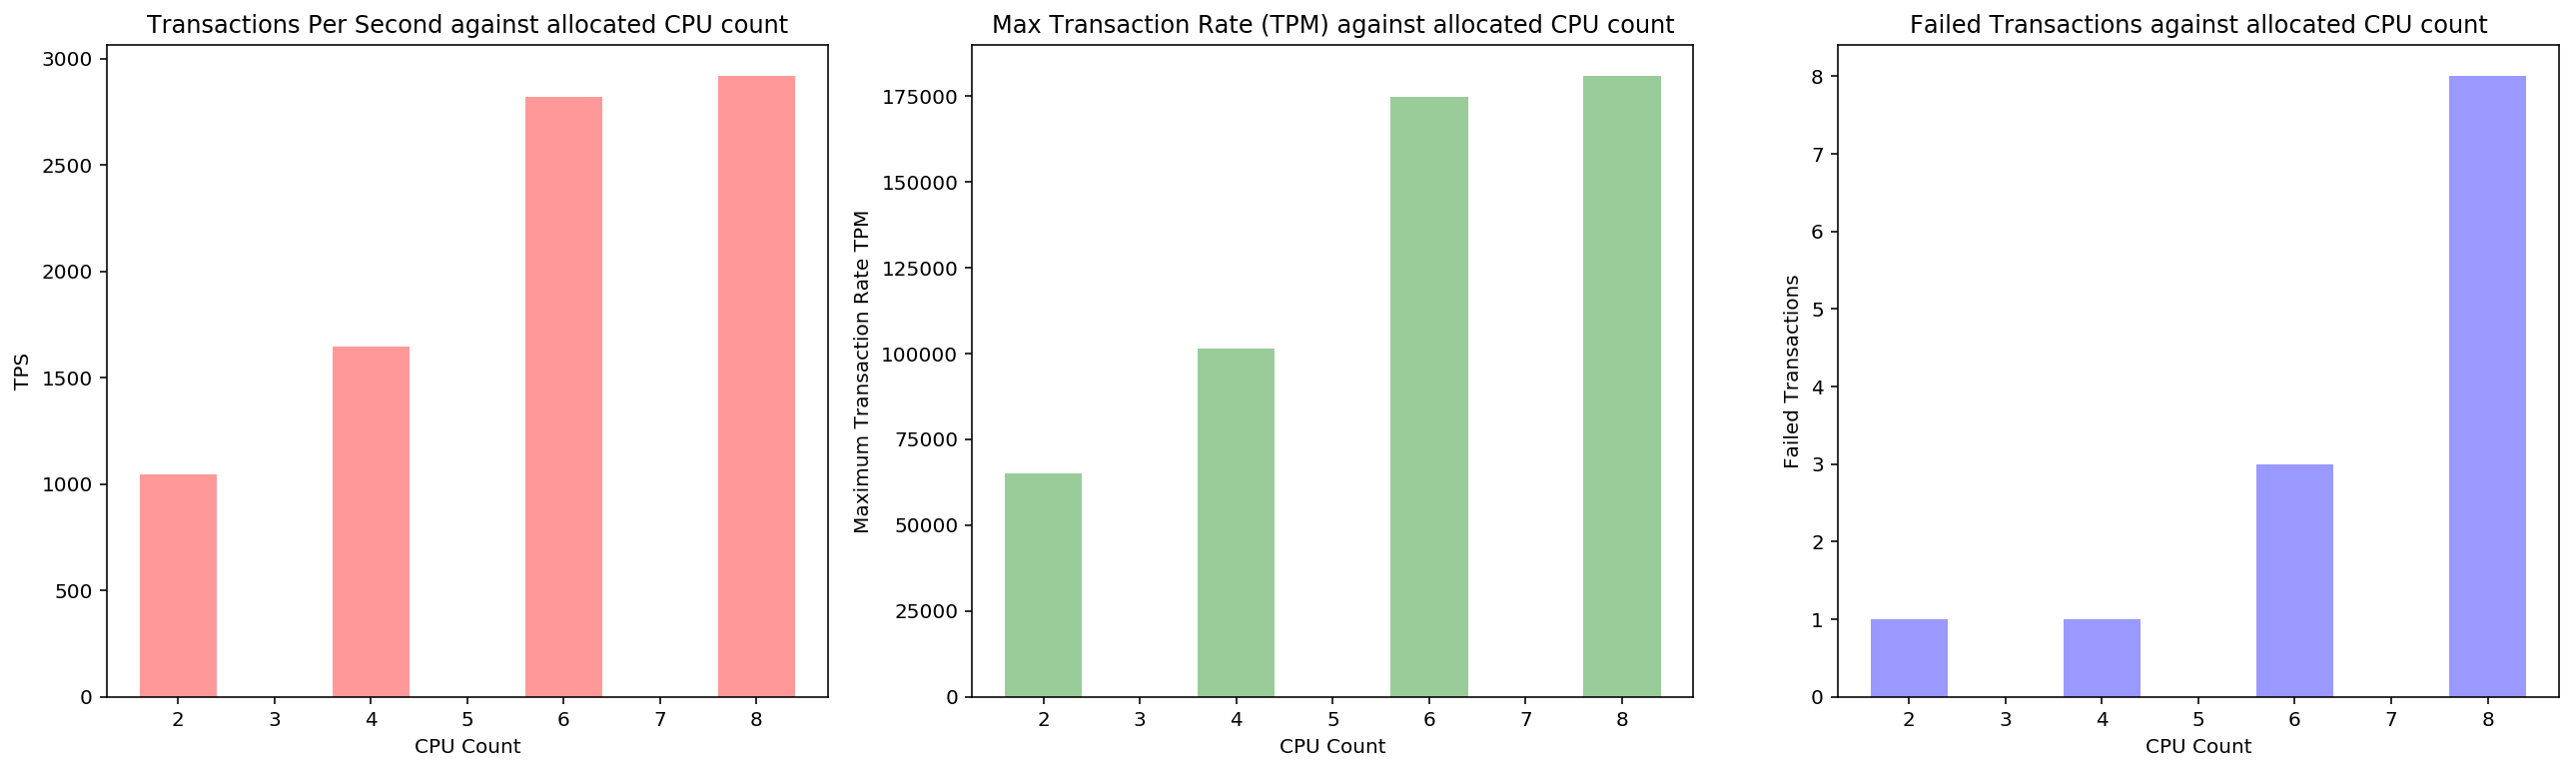

In [60]:
# Get the tags for the Overview Section
val:[ET.Element] = first_doc.findall(f".//{namespace}Overview/*")
overview_tags:[str] = [t.tag.split('}', 1)[1] for t in val]

# Format the results so they look reasonable    
table_values = {}
table_values["Description"] = overview_tags
for file_name, doc in sortedxmldocs.items():
    table_values[file_name] = [get_key_value(doc, 'Overview', key) for key in overview_tags]
overview_df = pd.DataFrame(table_values)
overview_df.set_index(['Description'],inplace=True)
display(overview_df)

# Plot the results of the tables
cpus = [int(cpu_from_string(s)) for s in overview_df.loc['AverageTransactionsPerSecond'].index]
average_TPS = overview_df.loc['AverageTransactionsPerSecond'].astype('float').values
fig=plt.figure(figsize=(22, 6))
plt.subplot(1, 3, 1)
plt.bar(x=cpus,height=average_TPS,color='r',alpha=0.4)
plt.xlabel("CPU Count")
plt.ylabel("TPS")
plt.title("Transactions Per Second against allocated CPU count")
plt.subplot(1, 3, 2)
failed_tx = overview_df.loc['MaximumTransactionRate'].astype('int32').values
plt.bar(x=cpus,height=failed_tx,color='g',alpha=0.4)
plt.xlabel("CPU Count")
plt.ylabel("Maximum Transaction Rate TPM")
plt.title("Max Transaction Rate (TPM) against allocated CPU count")
plt.subplot(1, 3, 3)
failed_tx = overview_df.loc['TotalFailedTransactions'].astype('int32').values
plt.bar(x=cpus,height=failed_tx,color='b',alpha=0.4)
plt.xlabel("CPU Count")
plt.ylabel("Failed Transactions")
ax = plt.title("Failed Transactions against allocated CPU count")

## Comparison of all Configuration Values

In [51]:
# Get the tags for the Overview Section
val:[ET.Element] = first_doc.findall(f".//{namespace}Configuration/*")
configuration_tags:[str] = [t.tag.split('}', 1)[1] for t in val]

table_values = {}
table_values["Description"] = configuration_tags
for file_name, doc in sortedxmldocs.items():
    table_values[file_name] = [get_key_value(doc, 'Configuration', key) for key in configuration_tags]
config_df = pd.DataFrame(table_values)
config_df.set_index(['Description'],inplace=True)
config_df

,results_scale10_uc64_cpu2.xml,results_scale10_uc64_cpu4.xml,results_scale10_uc64_cpu6.xml,results_scale10_uc64_cpu8.xml
Description,,,,
NumberOfUsers,64,64,64,64
MinimumInterThinkTime,0,0,0,0
MaximumInterThinkTime,0,0,0,0
MinimumIntraThinkTime,0,0,0,0
MaximumIntraThinkTime,0,0,0,0
ConnectString,//10.0.1.2/soe.sub09071537171.domnet.oraclevcn...,//10.0.1.2/soe.sub09071537171.domnet.oraclevcn...,//10.0.1.2/soe.sub09071537171.domnet.oraclevcn...,//10.0.1.2/soe.sub09071537171.domnet.oraclevcn...
TimingsIn,milliseconds,milliseconds,milliseconds,milliseconds
WaitTillAllLogon,true,true,true,true
Driver,oracle.jdbc.pool.OracleDataSource,oracle.jdbc.pool.OracleDataSource,oracle.jdbc.pool.OracleDataSource,oracle.jdbc.pool.OracleDataSource


## DML Operations

,results_scale10_uc64_cpu2.xml,results_scale10_uc64_cpu4.xml,results_scale10_uc64_cpu6.xml,results_scale10_uc64_cpu8.xml
Description,,,,
SelectStatements,1471108,2318223,3972815,4105919
InsertStatements,261870,409587,703700,727291
UpdateStatements,124890,194217,335167,345938
DeleteStatements,0,0,0,0
CommitStatements,161276,253202,434133,449541
RollbackStatements,1,1,3,8


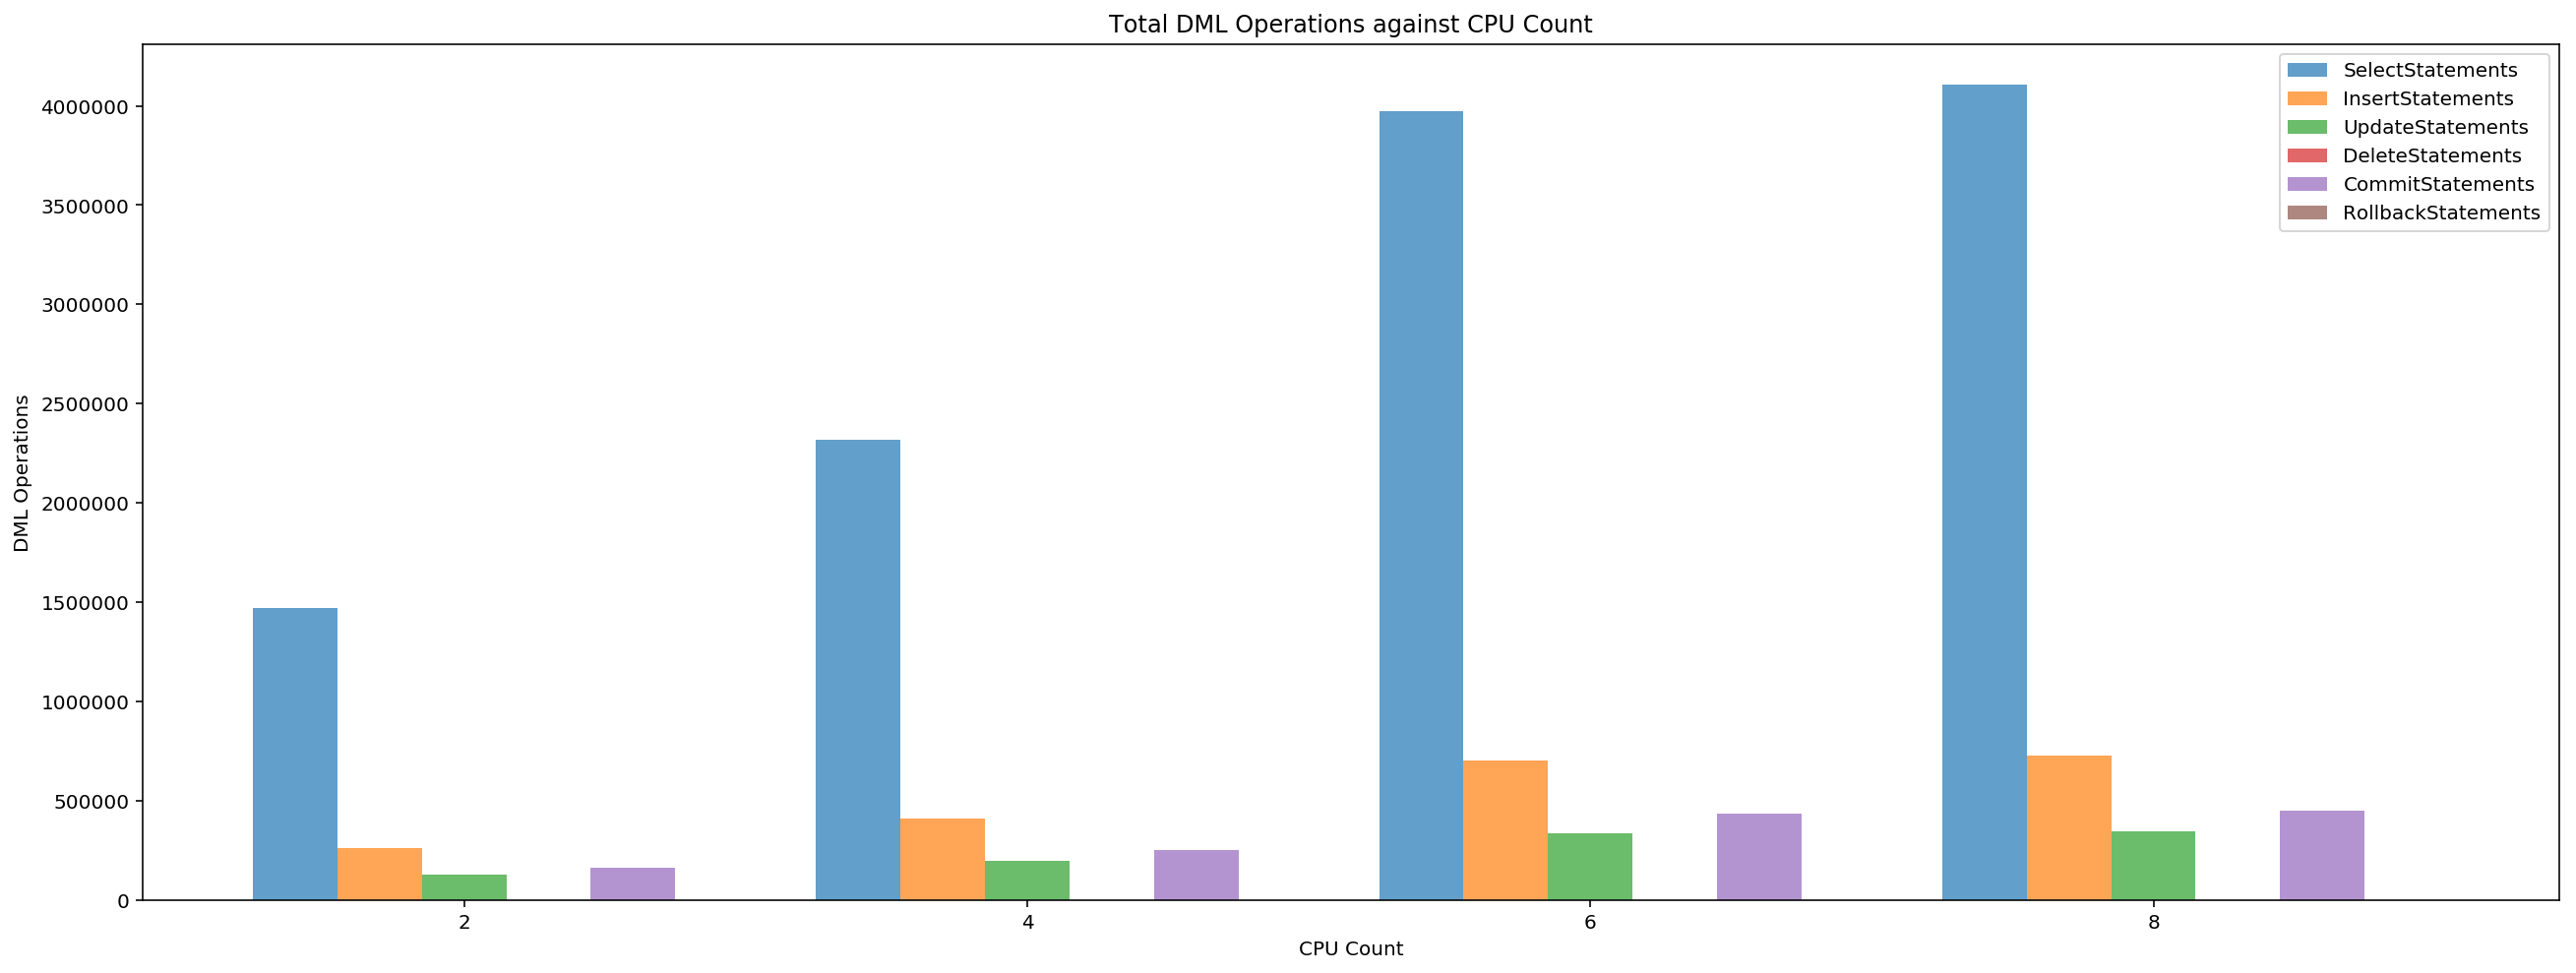

In [54]:
# Get the tags for the Overview Section
val:[ET.Element] = first_doc.findall(f".//{namespace}DMLResults/*")
dml_tags:[str] = [t.tag.split('}', 1)[1] for t in val]

table_values = {}
table_values["Description"] = dml_tags
for file_name, doc in sortedxmldocs.items():
    table_values[file_name] = [int(get_key_value(doc, 'DMLResults', key)) for key in dml_tags]
dml_df = pd.DataFrame(table_values)
dml_df.set_index(['Description'],inplace=True)
display(dml_df)

# Needs to change this to DML/Operations per sec
width = 0.15
index = np.arange(len(cpus))
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(8)
for offset, dml_type in enumerate(dml_keys):
    vals = dml_df.loc[dml_type].astype('int32').values
    rect = ax.bar(index+(width*offset), vals, width, alpha=0.7, label=dml_type)
ax.set_xticks(index + width / 0.5)
ax.set_xlabel("CPU Count")
ax.set_ylabel("DML Operations")
ax.set_title("Total DML Operations against CPU Count")
ax.legend()
labels = ax.set_xticklabels(cpus)

## Transaction Results

results_scale10_uc64_cpu2.xml  \
Transaction_id          Result                                                 
Customer Registration   AverageResponse                    56.35517305200814   
                        MinimumResponse                                    1   
                        MaximumResponse                                 4844   
                        TenthPrecentile                                    1   
                        TwentiethPercentile                                1   
                        ThirtiethPercentile                                1   
                        FortiethPrecentile                                 1   
                        FiftythPercentile                                  1   
                        SixtiethPercentile                                 1   
                        SeventiethPercentile                               1   
                        EightiethPercentile                                1   
                        NinetiethPercentile                                1   
                        TransactionCount                               10806   
                        FailedTransactionCount                             0   
                        RollbackCount                                      0   
Update Customer Details AverageResponse                    37.88826737519228   
                        MinimumResponse                                    1   
                        MaximumResponse                                 5184   
                        TenthPrecentile                                    1   
                        TwentiethPercentile                                1   
                        ThirtiethPercentile                                1   
                        FortiethPrecentile                                 1   
                        FiftythPercentile                                  1   
                        SixtiethPercentile                                 1   
                        SeventiethPercentile                               1   
                        EightiethPercentile                                1   
                        NinetiethPercentile                                1   
                        TransactionCount                                7151   
                        FailedTransactionCount                             0   
                        RollbackCount                                      0   
Browse Products         AverageResponse                    47.23795105894044   
                        MinimumResponse                                    1   
                        MaximumResponse                                 6972   
                        TenthPrecentile                                    2   
                        TwentiethPercentile                                2   
                        ThirtiethPercentile                                2   
                        FortiethPrecentile                                 2   
                        FiftythPercentile                                  2   
                        SixtiethPercentile                                 2   
                        SeventiethPercentile                               2   
                        EightiethPercentile                                2   
                        NinetiethPercentile                                2   
                        TransactionCount                               64404   
                        FailedTransactionCount                             0   
                        RollbackCount                                      0   
Order Products          AverageResponse                    94.51914449660929   
                        MinimumResponse                                    1   
                        MaximumResponse                                 7403   
                        TenthPrecentile        

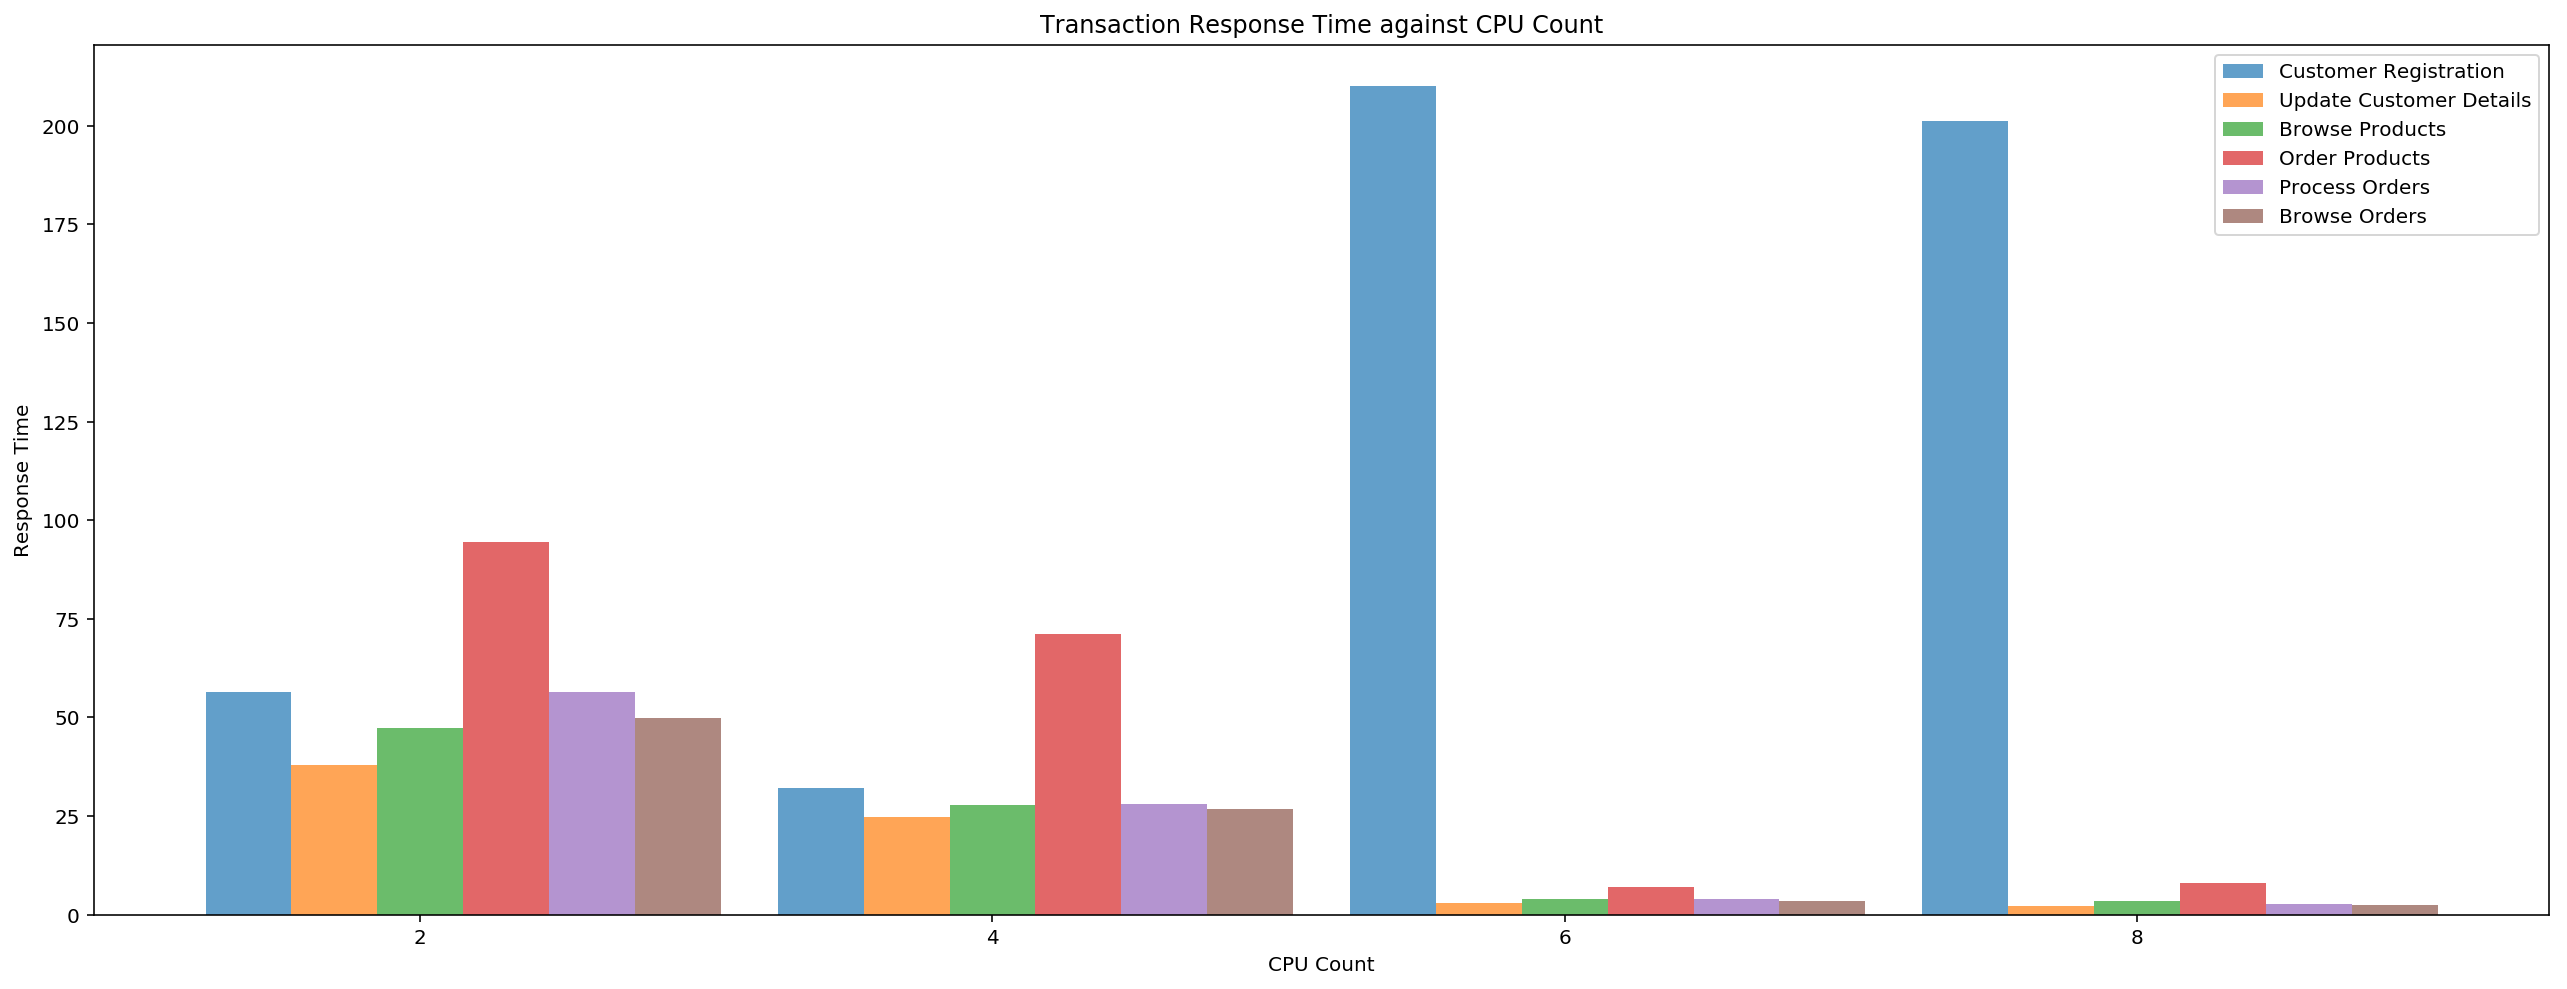

In [56]:
# Get the first doc and use it to get transactions and metric types
first_doc = list(sortedxmldocs.items())[0][1]
# Get a list of tuples containing the transaction id and result
tx_results:Tuple[str,ET.Element] = [(tx_result.attrib.get('id'),tx_result) for tx_result in first_doc.findall(f'.//{namespace}Result')]
# Get the names of the metrics
val:[ET.Element] = first_doc.findall(f".//*{namespace}Result[@id='{tx_results[0][0]}']/*")
metric_tags:[str] = [t.tag.split('}', 1)[1] for t in val]


df_array = []
for tx_name, tx_result in tx_results:
    file_results = {}
    for file_name, doc in sortedxmldocs.items():
        file_results[file_name] = [get_tx_results(doc, namespace, m , tx_name) for m in metric_tags]
    tx_frame = pd.DataFrame(file_results)
    tx_frame["Result"] = metric_tags
    tx_frame["Transaction_id"] = tx_name
    df_array.append(tx_frame)
df = pd.concat(df_array)
df.set_index(['Transaction_id','Result'], inplace=True)
pd.set_option('display.max_rows', 500)
display(df)

width = 0.15
index = np.arange(len(cpus))
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(8)
for offset,tx_id in enumerate(tx_results):
    vals = df.loc[(tx_id[0],'AverageResponse')].astype('float').values
    rect = ax.bar(index+(width*offset), vals, width, alpha=0.7, label=tx_id[0])
ax.set_xticks(index + width / 0.5)
ax.set_xlabel("CPU Count")
ax.set_ylabel("Response Time")
ax.set_title("Transaction Response Time against CPU Count")
ax.legend()
labels = ax.set_xticklabels(cpus)

## Database Wait Events
If you've enables database statistics collections the following section will display the wait events for each run and a series of charts.

,results_scale10_uc64_cpu2.xml_event,results_scale10_uc64_cpu2.xml_value,results_scale10_uc64_cpu4.xml_event,results_scale10_uc64_cpu4.xml_value,results_scale10_uc64_cpu6.xml_event,results_scale10_uc64_cpu6.xml_value,results_scale10_uc64_cpu8.xml_event,results_scale10_uc64_cpu8.xml_value
0,resmgr:cpu quantum,94.85,resmgr:cpu quantum,91.90,buffer busy waits,73.82,buffer busy waits,74.43
1,CPU Time,4.82,CPU Time,7.74,resmgr:cpu quantum,14.61,CPU Time,13.32
2,log file sync,0.20,log file sync,0.25,CPU Time,10.46,resmgr:cpu quantum,10.84
3,enq: TX - row lock contention,0.04,enq: TX - row lock contention,0.05,log file sync,0.67,log file sync,0.93
4,db file sequential read,0.03,PGA memory operation,0.02,enq: TX - index contention,0.35,enq: TX - index contention,0.37
5,buffer busy waits,0.01,db file sequential read,0.02,db file sequential read,0.02,PGA memory operation,0.02
6,SQL*Net break/reset to client,0.01,SQL*Net break/reset to client,0.01,latch: enqueue hash chains,0.02,latch: enqueue hash chains,0.02
7,read by other session,0.01,SQL*Net message to client,0.01,SQL*Net message to client,0.01,SQL*Net break/reset to client,0.02
8,enq: TX - index contention,0.01,buffer busy waits,0.00,SQL*Net break/reset to client,0.01,SQL*Net message to client,0.01
9,SQL*Net message to client,0.01,Disk file operations I/O,0.00,enq: TX - row lock contention,0.00,db file sequential read,0.01


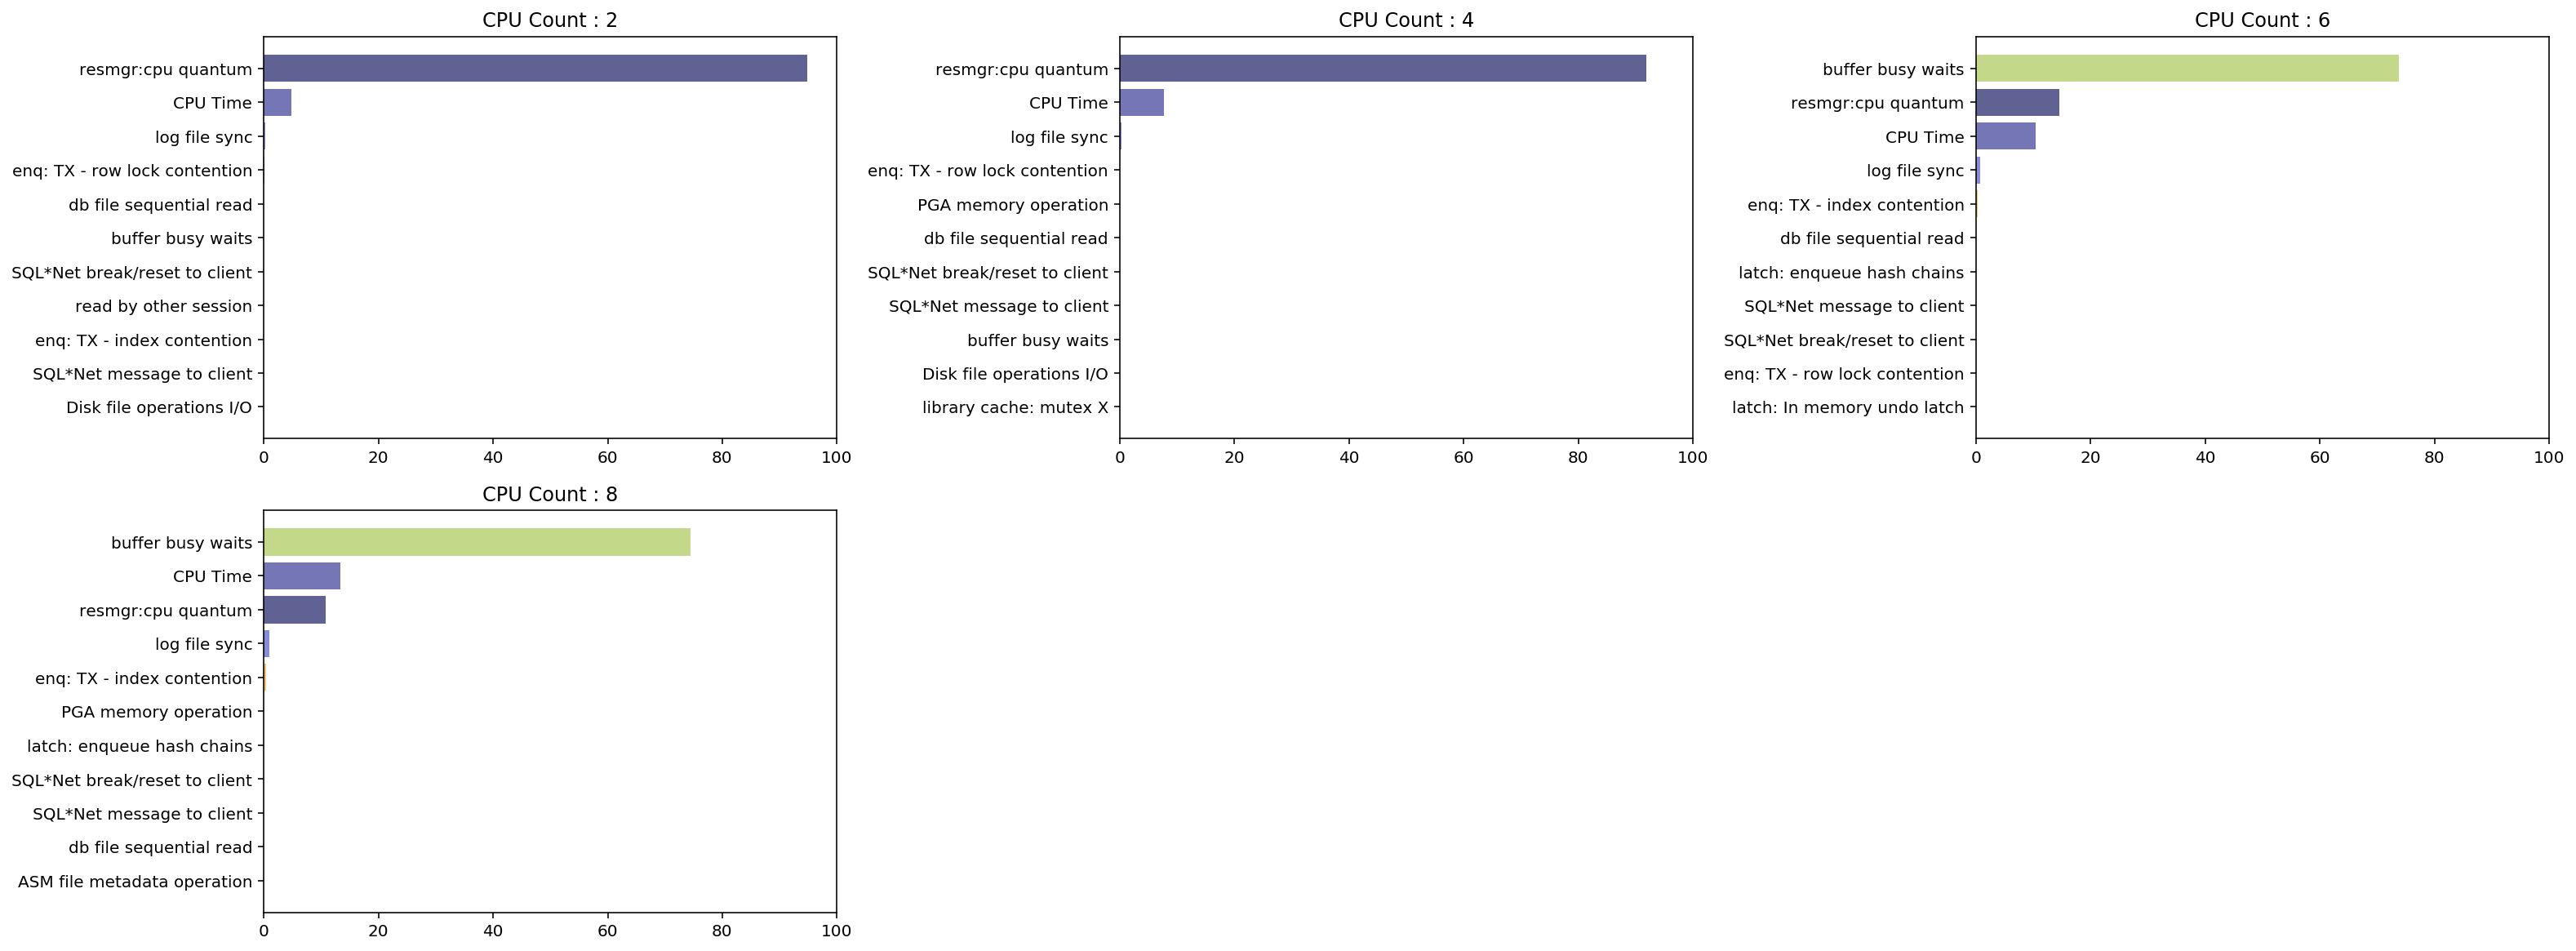

In [57]:
# Collect the data on wait events and print them out in a table
wait_events = {}
for file_name, doc in sortedxmldocs.items():
    wait_event:Tuple[str,ET.Element] = [(tx_result.attrib.get('name'),float(tx_result.attrib.get('percentageTimeWaited'))) for tx_result in doc.findall(f'.//{namespace}DatabaseWaitEvent')]
    res = list(zip(*wait_event)) 
    wait_events[f'{file_name}_event'] = res[0]
    wait_events[f'{file_name}_value'] = res[1]

wait_df = pd.DataFrame(wait_events)
display(wait_df)


# Try and get all of the unique strings for the wait events.
event_name_cols = [col for col in wait_df.columns if 'event' in col]
all_events = pd.concat(pd.Series(wait_df[s]) for s in event_name_cols).unique()

# Map a colour map to the unique number of events
cmap = plt.get_cmap('tab20b')
colors = cmap(np.linspace(0, 1, len(all_events)))

# Map Event names to the colours we've created
persisted_map = {}
for c in zip(all_events, colors):
    persisted_map[c[0]] = c[1]

    
# Plot the wait events
fig, ax = plt.subplots()
fig.set_figwidth(22)
fig.set_figheight(12)
counter = 1
for file_name, doc in sortedxmldocs.items():
    # Create a color array mapping names to colours
    event_colours = [persisted_map[x] for x in wait_df[f'{file_name}_event']]
    ax = plt.subplot(3, 3, counter)
    plt.barh(y=wait_df[f'{file_name}_event'],width=wait_df[f'{file_name}_value'],alpha=0.8,color=event_colours)
    ax.set_title(f'CPU Count : {cpu_from_string(file_name)}')
    ax.set_xlim(0,100)
    ax.invert_yaxis()
    plt.tight_layout()
    counter += 1
                                                    


## Database Statistics
If database statisitics are collected then they'll be displayed below. It's likely that you won't get the same number of stats back from the database for each run so there maybe a few discprencies when comparing.

In [42]:
db_stats = {}
for file_name, doc in sortedxmldocs.items():
    db_stat:Tuple[str,ET.Element] = [(dbs.attrib.get('name'),dbs.attrib.get('value')) for dbs in doc.findall(f'.//{namespace}DatabaseStatistic')]
    db_stats[f'{file_name}_name'], db_stats[f'{file_name}_value'] = list(zip(*db_stat))

# Join all the results from the file togther knowing that theymight not all have the same stats
dbs_df = pd.concat([pd.Series(v, name=k) for k, v in db_stats.items()], axis=1)
dbs_df


,results_scale10_uc64_cpu2.xml_name,results_scale10_uc64_cpu2.xml_value,results_scale10_uc64_cpu4.xml_name,results_scale10_uc64_cpu4.xml_value,results_scale10_uc64_cpu6.xml_name,results_scale10_uc64_cpu6.xml_value,results_scale10_uc64_cpu8.xml_name,results_scale10_uc64_cpu8.xml_value
0,IMU undo allocation size,392284192,IMU undo allocation size,611555584,IMU undo allocation size,1041500056,IMU undo allocation size,1010008728
1,scheduler wait time,719366,scheduler wait time,693447,scheduler wait time,109483,scheduler wait time,80793
2,redo synch time (usec),920984595,redo synch time (usec),767171301,redo synch time (usec),208862679,redo synch time (usec),187739438
3,physical reads,17355,physical reads,7876,physical reads,11111,physical reads,5801
4,ASSM gsp:get free block,5419,ASSM gsp:get free block,5807,ASSM gsp:get free block,16043,ASSM gsp:get free block,22962
5,KTFB alloc req,2,cursor reload failures,2,cursor reload failures,2,cursor reload failures,1
6,no work - consistent read gets,9207085,KTFB alloc req,3,KTFB alloc req,156,KTFB alloc req,175
7,ASSM gsp:L1 bitmaps examined,5951,no work - consistent read gets,27501491,no work - consistent read gets,24867300,no work - consistent read gets,48929202
8,enqueue waits,7,ASSM gsp:L1 bitmaps examined,6246,ASSM gsp:L1 bitmaps examined,16834,ASSM gsp:L1 bitmaps examined,23826
9,opened cursors current,577,enqueue waits,7,enqueue waits,6039,enqueue waits,6199
